### Analyze Auto sales trend and verify if RCF detects abrupt shift in sales
#### Years: 2005 to 2020.  This period covers recession due to housing crisis in 2008, followed by recovery and economic impact due to Covid
### Data Source:
Monthly New Vehicle Sales for the United States Automotive Market: https://www.goodcarbadcar.net/usa-auto-industry-total-sales-figures/<br>
Raw data: http://www.bea.gov/<br>

This script is based on AWS SageMaker Examples for Random Cut Forest: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/random_cut_forest/random_cut_forest.ipynb

In [1]:
import sys
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.dpi']=100

Matplotlib is building the font cache; this may take a moment.


In [2]:
import boto3
import botocore
import sagemaker


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
### Import s3 bucket name as environment variable

import os
env_vars = !cat ./.env
for var in env_vars:
    key, value = var.split('=')
    os.environ[key] = value

In [8]:
#os.environ['BUCKET_NAME']

In [4]:
bucket = os.environ['BUCKET_NAME']
prefix = 'sagemaker/autosales'
execution_role = sagemaker.get_execution_role()

In [5]:
# check wheter bucket exists

try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your s3 bucket'
         ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] =='403':
        print("Hey! You don't have permission to access the bucket, {}")
    elif e.response['Error']['Code'] =='404':
        print("Hey! your bucket {} doesn't exist!",format("MyBucket"))
    else:
        raise
        
else:
    print('Training input/output will be stored in: s3://{}/{}'.format("MyBucket",prefix))

Training input/output will be stored in: s3://MyBucket/sagemaker/autosales


In [6]:
%%time
data_filename = 'auto_sales_year_month.csv'
df = pd.read_csv(data_filename)

CPU times: user 5.51 ms, sys: 1.67 ms, total: 7.18 ms
Wall time: 59.5 ms


In [7]:
df.shape

(188, 2)

In [8]:
df

,timestamp,value
0,2005-01-01,1052224.0
1,2005-02-01,1244753.0
2,2005-03-01,1564938.0
3,2005-04-01,1493837.0
4,2005-05-01,1488171.0
...,...,...
183,2020-04-01,563122.0
184,2020-05-01,1181756.0
185,2020-06-01,1214706.0
186,2020-07-01,481587.0


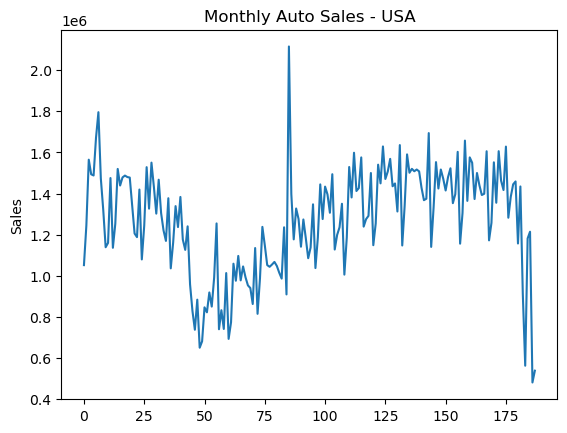

In [11]:
plt.plot(df['value'])
plt.ylabel('Sales')
plt.title('Monthly Auto Sales - USA')
plt.show()

### Big increase in auto sales Feb 2012

In [12]:
df[75:90]

,timestamp,value
75,2011-04-01,1149240.0
76,2011-05-01,1052417.0
77,2011-06-01,1044037.0
78,2011-07-01,1055231.0
79,2011-08-01,1067895.0
80,2011-09-01,1048158.0
81,2011-10-01,1015016.0
82,2011-11-01,986664.0
83,2011-12-01,1236129.0
84,2012-01-01,909806.0


### Autosales hit record low in April 2020

In [13]:
df[175:]

,timestamp,value
175,2019-08-01,1628577.0
176,2019-09-01,1282712.0
177,2019-10-01,1384010.0
178,2019-11-01,1445173.0
179,2019-12-01,1459164.0
180,2020-01-01,1157415.0
181,2020-02-01,1434716.0
182,2020-03-01,912800.0
183,2020-04-01,563122.0
184,2020-05-01,1181756.0


### Training

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [15]:
use_spot_instances = True
max_run = 3600
max_wait = 3600 if use_spot_instances else None

job_name = 'rcf-autosales'

checkpoint_s3_uri = None

if use_spot_instances:
    checkpoint_s3_uri = f's3://{bucket}/{prefix}/checkpoints/{job_name}'



In [18]:
#print(checkpoint_s3_uri)

In [36]:
from sagemaker import RandomCutForest

session = sagemaker.Session()
# specify general training information
# 48 samples = 48 months of data

rcf = RandomCutForest(role=execution_role,
                      instance_count=1,
                      instance_type='ml.m5.xlarge',
                      data_location='s3://{}/{}/'.format(bucket,prefix),
                      output_path='s3://{}/{}/output'.format(bucket,prefix),
                      num_samples_per_tree=48,
                      num_trees=50,
                      base_job_name=job_name,
                      use_spot_instances=use_spot_instances,
                      max_run=max_run,
                      max_wait=max_wait,
                      checkpoint_s3_uri=checkpoint_s3_uri
                     )



In [38]:
rcf.fit(rcf.record_set(df.value.to_numpy().reshape(-1,1)))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: rcf-autosales-2024-06-26-16-37-28-322


2024-06-26 16:37:28 Starting - Starting the training job...
2024-06-26 16:37:43 Starting - Preparing the instances for training...
2024-06-26 16:38:16 Downloading - Downloading input data...
2024-06-26 16:38:37 Downloading - Downloading the training image.........
2024-06-26 16:40:22 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[06/26/2024 16:40:35 INFO 139899310806848] Reading default configuration fr

[06/26/2024 16:40:36 INFO 139899310806848] Cluster sharing facilities started.
[06/26/2024 16:40:36 INFO 139899310806848] Verifying all workers are accessible...
[06/26/2024 16:40:36 INFO 139899310806848] All workers accessible.
[06/26/2024 16:40:36 INFO 139899310806848] Initializing Sampler...
[06/26/2024 16:40:36 INFO 139899310806848] Sampler correctly initialized.
#metrics {"StartTime": 1719420035.5473535, "EndTime": 1719420036.5437105, "Dimensions": {"Algorithm": "RandomCutForest", "Host": "algo-1", "Operation": "training"}, "Metrics": {"initialize.time": {"sum": 995.0160980224609, "count": 1, "min": 995.0160980224609, "max": 995.0160980224609}}}
#metrics {"StartTime": 1719420036.5438695, "EndTime": 1719420036.5439036, "Dimensions": {"Algorithm": "RandomCutForest", "Host": "algo-1", "Operation": "training", "Meta": "init_train_data_iter"}, "Metrics": {"Total Records Seen": {"sum": 0.0, "count": 1, "min": 0, "max": 0}, "Total Batches Seen": {"sum": 0.0, "count": 1, "min": 0, "max": 

In [39]:
rcf.hyperparameters()

{'num_samples_per_tree': '48',
 'num_trees': '50',
 'feature_dim': '1',
 'mini_batch_size': '1000'}

In [40]:
print('Training job name:{}'.format(rcf.latest_training_job.job_name))

Training job name:rcf-autosales-2024-06-26-16-37-28-322


# Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [41]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    endpoint_name=job_name
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: rcf-autosales-2024-06-26-16-44-23-105
INFO:sagemaker:Creating endpoint-config with name rcf-autosales
INFO:sagemaker:Creating endpoint with name rcf-autosales


------!

In [43]:
print('Endpoint name: {}'.format(rcf_inference.endpoint_name))

Endpoint name: rcf-autosales


### Data Serialization/Deserialization

In [9]:
# SDK 2.0 serializers

from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

NameError: name 'rcf_inference' is not defined

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [49]:
df_numpy = df.value.to_numpy().reshape(-1,1)
print(df_numpy[:6])

[[1052224.]
 [1244753.]
 [1564938.]
 [1493837.]
 [1488171.]
 [1671401.]]


In [51]:
results = rcf_inference.predict(df_numpy[:6])
print(results)

{'scores': [{'score': 1.001011077}, {'score': 0.9167631834}, {'score': 1.0405018806}, {'score': 0.925923901}, {'score': 0.9199087141}, {'score': 1.174596793}]}


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire taxi dataset.

In [57]:
results = rcf_inference.predict(df_numpy)
scores = [datum['score'] for datum in results['scores']]

In [55]:
[datum['score'] for datum in results['scores']]

[1.001011077,
 0.9167631834,
 1.0405018806,
 0.925923901,
 0.9199087141,
 1.174596793]

In [56]:
import numpy as np

In [58]:
np.savetxt("scores_individual_data_point.csv",
          np.asarray(scores),
          delimiter=',',
          fmt='%10.5f')

In [59]:
# add scores to taxi data frame
df['score']= pd.Series(scores,index=df.index)
df.head()

,timestamp,value,score
0,2005-01-01,1052224.0,1.001011
1,2005-02-01,1244753.0,0.916763
2,2005-03-01,1564938.0,1.040502
3,2005-04-01,1493837.0,0.925924
4,2005-05-01,1488171.0,0.919909


(0.8927140914, 1.93092823784)

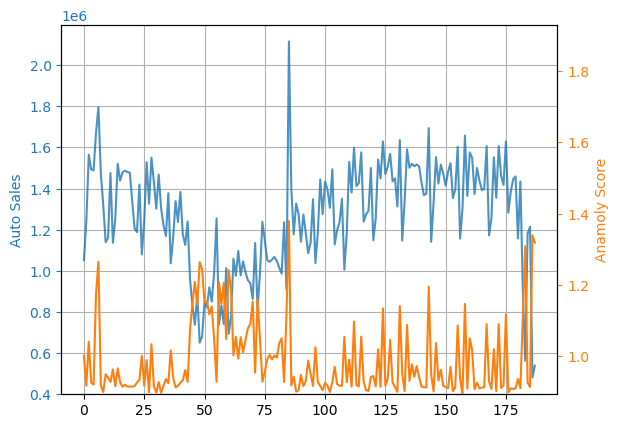

In [61]:
fig, ax1 = plt.subplots()
ax2=ax1.twinx()

# *Try this out* - change 'start' and 'end' to zoom in on the
# anamol found earlier in this notebook

start, end = 0, len(df)

df_subset = df.loc[start:end]

ax1.plot(df_subset['value'],color='C0', alpha=0.8)
ax2.plot(df_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Auto Sales', color="C0")
ax2.set_ylabel('Anamoly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y',colors='C1')

ax2.set_ylim(min(scores),1.4*max(scores))

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than 3 standard deviations (approx 99.9th percentile) from the mean score.

In [62]:
score_mean = df['score'].mean()
score_std = df['score'].std()
score_cutoff = score_mean + 2.0*score_std

In [65]:
anamolies = df_subset[df_subset['score']>score_cutoff]
anamolies

,timestamp,value,score
6,2005-07-01,1795944.0,1.264664
46,2008-11-01,737978.0,1.208332
48,2009-01-01,650608.0,1.264004
49,2009-02-01,681676.0,1.244646
56,2009-09-01,740394.0,1.206651
58,2009-11-01,741826.0,1.205731
60,2010-01-01,693531.0,1.241393
85,2012-02-01,2115420.0,1.379234
183,2020-04-01,563122.0,1.308603
186,2020-07-01,481587.0,1.339143


In [66]:
score_mean, score_std, score_cutoff

(0.9892007259271276, 0.10470335151074832, 1.1986074289486242)

In [67]:
ax2.plot(anamolies.index, anamolies.score, 'ko')

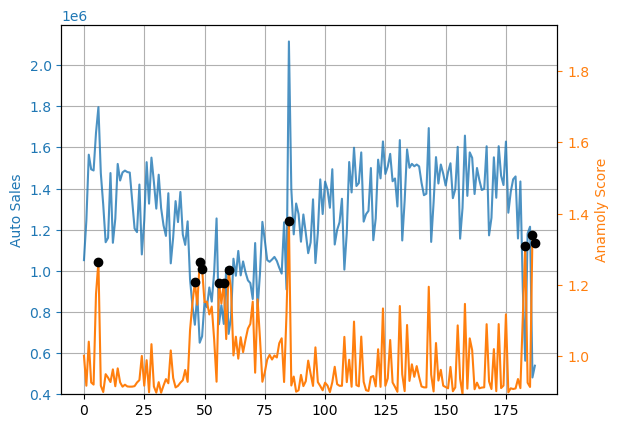

In [68]:
fig

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

In [69]:
### Delete Endpoint

rcf_inference.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: rcf-autosales
INFO:sagemaker:Deleting endpoint with name: rcf-autosales


# Epilogue

---

We used Amazon SageMaker Random Cut Forest to detect anomalous datapoints in a taxi ridership dataset. In these data the anomalies occurred when ridership was uncharacteristically high or low. However, the RCF algorithm is also capable of detecting when, for example, data breaks periodicity or uncharacteristically changes global behavior.

Depending on the kind of data you have there are several ways to improve algorithm performance. One method, for example, is to use an appropriate training set. If you know that a particular set of data is characteristic of "normal" behavior then training on said set of data will more accurately characterize "abnormal" data.

Another improvement is make use of a windowing technique called "shingling". This is especially useful when working with periodic data with known period, such as the NYC taxi dataset used above. The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [10]:
df.head()

,timestamp,value
0,2005-01-01,1052224.0
1,2005-02-01,1244753.0
2,2005-03-01,1564938.0
3,2005-04-01,1493837.0
4,2005-05-01,1488171.0


In [14]:
import numpy as np

def shingle(data, shingle_size):
    num_data = len(data)
    
    shingled_data = np.zeros((num_data-shingle_size+1, shingle_size))
    
    for n in range(num_data - shingle_size+1):
        shingled_data[n] = data[n:(n+shingle_size)]
    
    return shingled_data
    

In [15]:
# single data with shingle size=3 

shingle_size = 3
prefix_shigled = 'sagemaker/randomcutforest_shingled'
auto_data_shingled = shingle(df.values[:,1], shingle_size)

In [34]:
use_spot_instances = True
max_run = 3600
max_wait = 3600 if use_spot_instances else None

job_name = 'rcf-autosales-shingled'

checkpoint_s3_uri = None

if use_spot_instances:
    checkpoint_s3_uri= f's3://{bucket}/{prefix_shigled}/checkpoint/{job_name}'


In [35]:
#print(checkpoint_s3_uri)

In [20]:
df[:4]

,timestamp,value
0,2005-01-01,1052224.0
1,2005-02-01,1244753.0
2,2005-03-01,1564938.0
3,2005-04-01,1493837.0


In [21]:
df.values[:4]

array([['2005-01-01', 1052224.0],
       ['2005-02-01', 1244753.0],
       ['2005-03-01', 1564938.0],
       ['2005-04-01', 1493837.0]], dtype=object)

In [23]:
df.values[:5,1]

array([1052224.0, 1244753.0, 1564938.0, 1493837.0, 1488171.0],
      dtype=object)

In [28]:
shingle(df.values[:7,1],2)

array([[1052224., 1244753.],
       [1244753., 1564938.],
       [1564938., 1493837.],
       [1493837., 1488171.],
       [1488171., 1671401.],
       [1671401., 1795944.]])

In [27]:
auto_data_shingled[:5]

array([[1052224., 1244753., 1564938.],
       [1244753., 1564938., 1493837.],
       [1564938., 1493837., 1488171.],
       [1493837., 1488171., 1671401.],
       [1488171., 1671401., 1795944.]])

In [29]:
auto_data_shingled[-5:]

array([[1434716.,  912800.,  563122.],
       [ 912800.,  563122., 1181756.],
       [ 563122., 1181756., 1214706.],
       [1181756., 1214706.,  481587.],
       [1214706.,  481587.,  538854.]])

In [30]:
auto_data_shingled.shape

(186, 3)

In [31]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

In [36]:
# Create a new training job and inference endpoint.

rcf = RandomCutForest(
        role=execution_role,
        instance_count=1,
        instance_type='ml.m5.xlarge',
        data_location='s3://{}/{}/'.format(bucket, prefix_shigled),
        output_path ='s3://{}/{}/output'.format(bucket,prefix_shigled),
        num_samples_per_tree=48,
        num_trees=50,
        base_job_name=job_name,
        use_spot_instances=use_spot_instances,
        max_run=max_run,
        max_wait=max_wait,
        checkpoint_s3_uri = checkpoint_s3_uri
)

In [37]:
rcf.fit(rcf.record_set(auto_data_shingled))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: rcf-autosales-shingled-2024-06-26-22-47-11-841


2024-06-26 22:47:12 Starting - Starting the training job...
2024-06-26 22:47:27 Starting - Preparing the instances for training...
2024-06-26 22:47:57 Downloading - Downloading input data...
2024-06-26 22:48:17 Downloading - Downloading the training image......
2024-06-26 22:49:28 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[06/26/2024 22:49:38 INFO 139947228546880] Reading default configuration from 


2024-06-26 22:49:55 Uploading - Uploading generated training model
2024-06-26 22:49:55 Completed - Training job completed
Training seconds: 118
Billable seconds: 50
Managed Spot Training savings: 57.6%


In [38]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: rcf-autosales-shingled-2024-06-26-22-47-11-841


In [39]:
rcf.hyperparameters()

{'num_samples_per_tree': '48',
 'num_trees': '50',
 'feature_dim': '3',
 'mini_batch_size': '1000'}

In [40]:
# SDK 2.0 Serializzers
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

In [41]:
rcf_inference = rcf.deploy(
                        initial_instance_count=1,
                        instance_type='ml.m5.xlarge',
                        endpoint_name=job_name
                    )

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: rcf-autosales-shingled-2024-06-26-22-54-11-240
INFO:sagemaker:Creating endpoint-config with name rcf-autosales-shingled
INFO:sagemaker:Creating endpoint with name rcf-autosales-shingled


-------!

In [42]:
# Using above inference endpoint we compute the anamoly scores with the shingled data

# Score the shingled datapoints

results = rcf_inference.predict(auto_data_shingled)
scores = np.array([datum['score'] for datum in results['scores']])

In [43]:
# save scores

np.savetxt("scores_shingled_quaterly.csv",
          np.asarray(scores),
          delimiter=",",
          fmt='%10.5f')

In [57]:
# Compute the shingled score distribution and cutoff to determine anamolies

score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 2.0*score_std

score_mean, score_std, score_cutoff

(1.0337175077215055, 0.0849324687356834, 1.2035824451928723)

In [58]:
anomalies = scores[scores>score_cutoff]
anomaly_indices = np.arange(len(scores))[scores>score_cutoff]

print(anomalies)

[1.2226491  1.23744714 1.2562867  1.20580313 1.20787335 1.2037501
 1.21784198 1.25562097 1.2583918  1.23616222 1.225904   1.28909196]


In [59]:
anomaly_indices

array([ 46,  47,  48,  49,  56,  58,  59,  83,  84,  85, 181, 185])

In [60]:
scores.size

186

In [61]:
anomalies.shape

(12,)

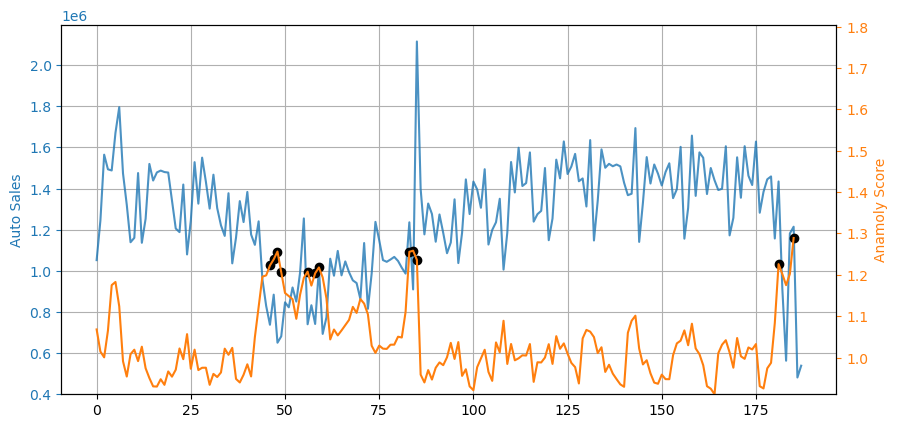

In [64]:
# plot the scores from the shingled data on top of original dataset

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

start, end = 0, len(df)
taxi_data_subset = df.loc[start:end]

ax1.plot(df['value'], color='C0', alpha=0.8)
ax2.plot(scores, color='C1')
ax2.scatter(anomaly_indices, anomalies, color='k')

ax1.grid(which='major', axis='both')
ax1.set_ylabel('Auto Sales', color='C0')
ax2.set_ylabel('Anamoly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [65]:
# delete the endpoint

rcf_inference.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: rcf-autosales-shingled
INFO:sagemaker:Deleting endpoint with name: rcf-autosales-shingled
